# Sprint 23 - Gated Recurrent Neural Network

## Problem 1

- LSTM

In [1]:
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb

max_features = 20000
# cut texts after this number of words (among top max_features most common words)
maxlen = 80
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=5,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)


Using TensorFlow backend.


Loading data...
17465344/17464789 [==============================] - 30s 2us/step
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)
Build model...
Train...


/Users/diopmouhamed/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 74s 3ms/step - loss: 0.4609 - accuracy: 0.7850 - val_loss: 0.3699 - val_accuracy: 0.8382
Epoch 2/5
25000/25000 [==============================] - 73s 3ms/step - loss: 0.2986 - accuracy: 0.8775 - val_loss: 0.3854 - val_accuracy: 0.8304
Epoch 3/5
25000/25000 [==============================] - 74s 3ms/step - loss: 0.2176 - accuracy: 0.9167 - val_loss: 0.4429 - val_accuracy: 0.8325
Epoch 4/5
25000/25000 [==============================] - 71s 3ms/step - loss: 0.1628 - accuracy: 0.9384 - val_loss: 0.4706 - val_accuracy: 0.8264
Epoch 5/5
25000/25000 [==============================] - 12s 486us/step
Test score: 0.6228169191169739
Test accuracy: 0.802079975605011


- ConvLSTM2D

Train on 950 samples, validate on 50 samples
Epoch 1/2
950/950 [==============================] - 684s 720ms/step - loss: 0.2458 - val_loss: 0.5495
Epoch 2/2
950/950 [==============================] - 668s 703ms/step - loss: 0.0209 - val_loss: 0.3379


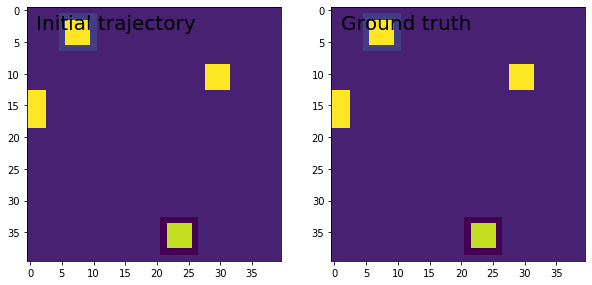

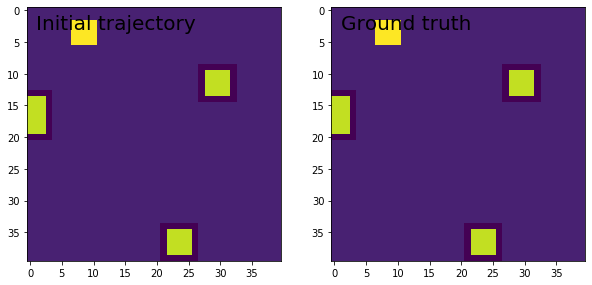

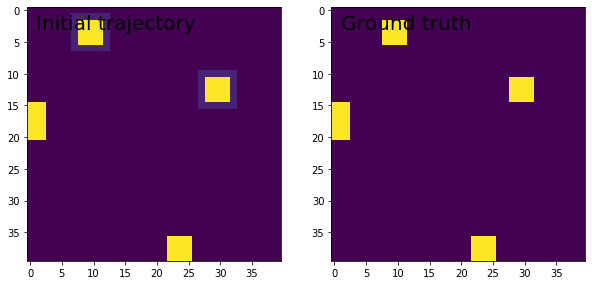

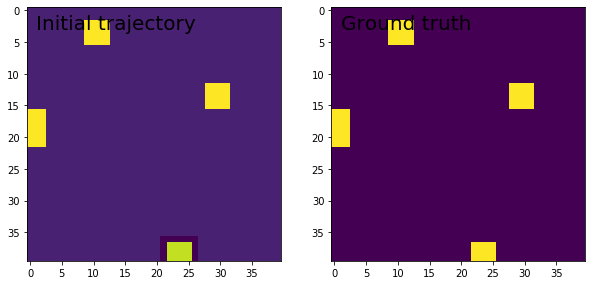

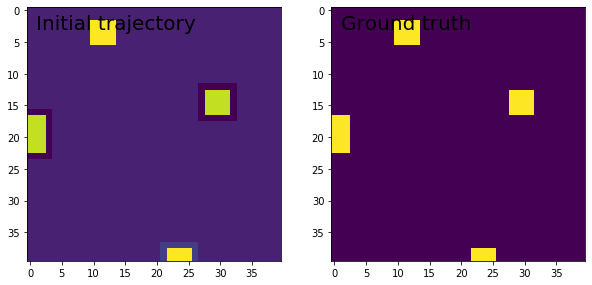

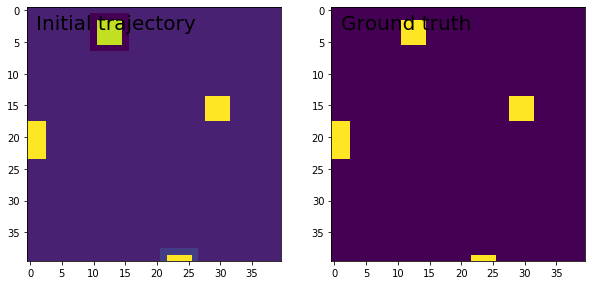

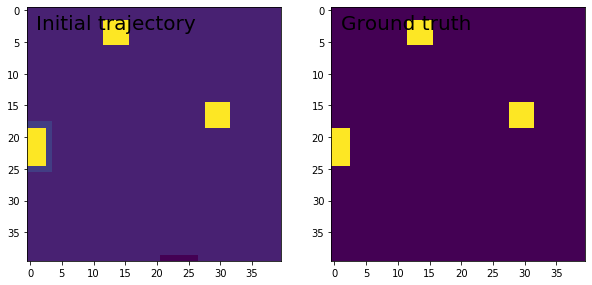

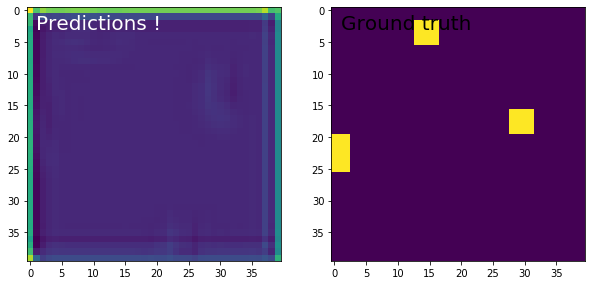

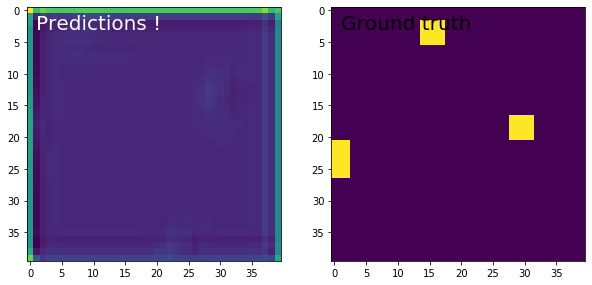

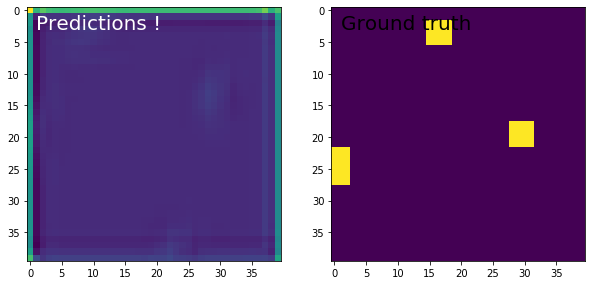

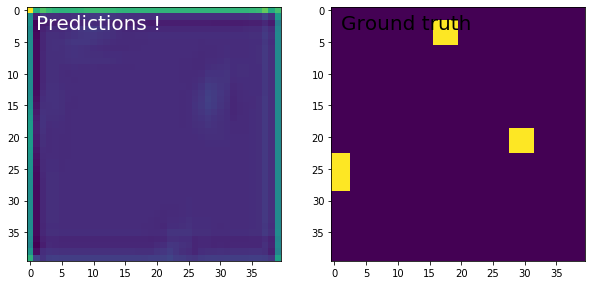

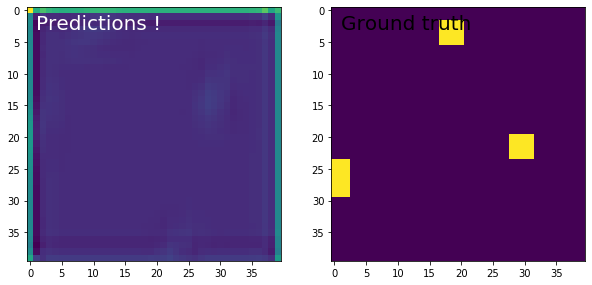

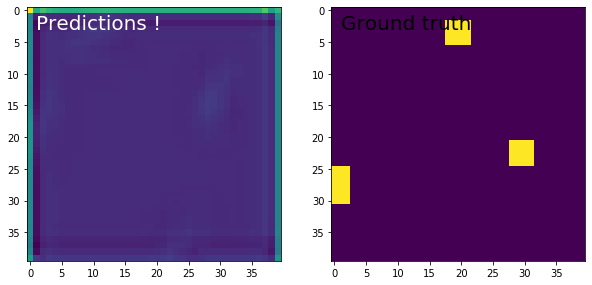

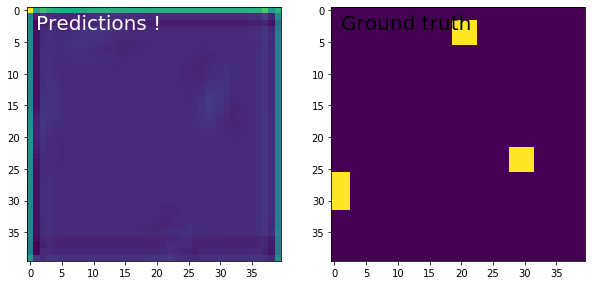

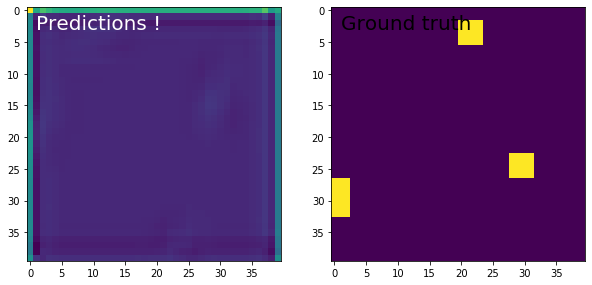

In [4]:
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
import numpy as np
import pylab as plt

# We create a layer which take as input movies of shape
# (n_frames, width, height, channels) and returns a movie
# of identical shape.

seq = Sequential()
seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   input_shape=(None, 40, 40, 1),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
               activation='sigmoid',
               padding='same', data_format='channels_last'))
seq.compile(loss='binary_crossentropy', optimizer='adadelta')


# Artificial data generation:
# Generate movies with 3 to 7 moving squares inside.
# The squares are of shape 1x1 or 2x2 pixels,
# which move linearly over time.
# For convenience we first create movies with bigger width and height (80x80)
# and at the end we select a 40x40 window.

def generate_movies(n_samples=1200, n_frames=15):
    row = 80
    col = 80
    noisy_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float)
    shifted_movies = np.zeros((n_samples, n_frames, row, col, 1),
                              dtype=np.float)

    for i in range(n_samples):
        # Add 3 to 7 moving squares
        n = np.random.randint(3, 8)

        for j in range(n):
            # Initial position
            xstart = np.random.randint(20, 60)
            ystart = np.random.randint(20, 60)
            # Direction of motion
            directionx = np.random.randint(0, 3) - 1
            directiony = np.random.randint(0, 3) - 1

            # Size of the square
            w = np.random.randint(2, 4)

            for t in range(n_frames):
                x_shift = xstart + directionx * t
                y_shift = ystart + directiony * t
                noisy_movies[i, t, x_shift - w: x_shift + w,
                             y_shift - w: y_shift + w, 0] += 1

                # Make it more robust by adding noise.
                # The idea is that if during inference,
                # the value of the pixel is not exactly one,
                # we need to train the network to be robust and still
                # consider it as a pixel belonging to a square.
                if np.random.randint(0, 2):
                    noise_f = (-1)**np.random.randint(0, 2)
                    noisy_movies[i, t,
                                 x_shift - w - 1: x_shift + w + 1,
                                 y_shift - w - 1: y_shift + w + 1,
                                 0] += noise_f * 0.1

                # Shift the ground truth by 1
                x_shift = xstart + directionx * (t + 1)
                y_shift = ystart + directiony * (t + 1)
                shifted_movies[i, t, x_shift - w: x_shift + w,
                               y_shift - w: y_shift + w, 0] += 1

    # Cut to a 40x40 window
    noisy_movies = noisy_movies[::, ::, 20:60, 20:60, ::]
    shifted_movies = shifted_movies[::, ::, 20:60, 20:60, ::]
    noisy_movies[noisy_movies >= 1] = 1
    shifted_movies[shifted_movies >= 1] = 1
    return noisy_movies, shifted_movies

# Train the network
noisy_movies, shifted_movies = generate_movies(n_samples=1200)
seq.fit(noisy_movies[:1000], shifted_movies[:1000], batch_size=10,
        epochs=2, validation_split=0.05)

# Testing the network on one movie
# feed it with the first 7 positions and then
# predict the new positions
which = 1004
track = noisy_movies[which][:7, ::, ::, ::]

for j in range(16):
    new_pos = seq.predict(track[np.newaxis, ::, ::, ::, ::])
    new = new_pos[::, -1, ::, ::, ::]
    track = np.concatenate((track, new), axis=0)


# And then compare the predictions
# to the ground truth
track2 = noisy_movies[which][::, ::, ::, ::]
for i in range(15):
    fig = plt.figure(figsize=(10, 5))

    ax = fig.add_subplot(121)

    if i >= 7:
        ax.text(1, 3, 'Predictions !', fontsize=20, color='w')
    else:
        ax.text(1, 3, 'Initial trajectory', fontsize=20)

    toplot = track[i, ::, ::, 0]

    plt.imshow(toplot)
    ax = fig.add_subplot(122)
    plt.text(1, 3, 'Ground truth', fontsize=20)

    toplot = track2[i, ::, ::, 0]
    if i >= 2:
        toplot = shifted_movies[which][i - 1, ::, ::, 0]

    plt.imshow(toplot)
    plt.savefig('%i_animate.png' % (i + 1))

- SimpleRNN

In [3]:
from keras.layers.recurrent import SimpleRNN

max_features = 20000
# cut texts after this number of words (among top max_features most common words)
maxlen = 80
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(SimpleRNN(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=5,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)


Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)
Build model...
Train...


/Users/diopmouhamed/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 33s 1ms/step - loss: 0.6823 - accuracy: 0.5439 - val_loss: 0.6460 - val_accuracy: 0.5955
Epoch 2/5
25000/25000 [==============================] - 33s 1ms/step - loss: 0.5823 - accuracy: 0.6882 - val_loss: 0.5734 - val_accuracy: 0.6972
Epoch 3/5
25000/25000 [==============================] - 32s 1ms/step - loss: 0.4866 - accuracy: 0.7661 - val_loss: 0.5189 - val_accuracy: 0.7509
Epoch 4/5
25000/25000 [==============================] - 33s 1ms/step - loss: 0.4242 - accuracy: 0.8082 - val_loss: 0.5024 - val_accuracy: 0.7772
Epoch 5/5
25000/25000 [==============================] - 3s 139us/step
Test score: 0.5572846227645875
Test accuracy: 0.7554399967193604


- GRU

In [5]:
from keras.layers.recurrent import GRU

max_features = 20000
# cut texts after this number of words (among top max_features most common words)
maxlen = 80
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(GRU(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=5,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)
Build model...
Train...


/Users/diopmouhamed/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 77s 3ms/step - loss: 1.0152 - accuracy: 0.7089 - val_loss: 0.5635 - val_accuracy: 0.7013
Epoch 2/5
25000/25000 [==============================] - 74s 3ms/step - loss: 0.5168 - accuracy: 0.7681 - val_loss: 0.5629 - val_accuracy: 0.7029
Epoch 3/5
25000/25000 [==============================] - 76s 3ms/step - loss: 0.4596 - accuracy: 0.8048 - val_loss: 0.5758 - val_accuracy: 0.6972
Epoch 4/5
25000/25000 [==============================] - 76s 3ms/step - loss: 0.3710 - accuracy: 0.8441 - val_loss: 0.5963 - val_accuracy: 0.6913
Epoch 5/5
25000/25000 [==============================] - 9s 376us/step
Test score: 0.6112297657585144
Test accuracy: 0.686240017414093


## Problem 2

- Let's use another dataset'

In [7]:
from keras.datasets import reuters
from keras.utils import to_categorical

max_features = 20000
# cut texts after this number of words (among top max_features most common words)
maxlen = 100
batch_size = 32

(x_train, y_train), (x_test, y_test) = reuters.load_data(path="reuters.npz",
                                                         num_words=max_features,
                                                         skip_top=0,
                                                         maxlen=None,
                                                         test_split=0.2,
                                                         seed=113,
                                                         start_char=1,
                                                         oov_char=2,
                                                         index_from=3)

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
num_classes = y_train.shape[1]

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=5,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Pad sequences (samples x time)
x_train shape: (8982, 100)
x_test shape: (2246, 100)
Build model...
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_4 (Dense)              (None, 46)                5934      
Total params: 2,697,518
Trainable params: 2,697,518
Non-trainable params: 0
_________________________________________________________________
Train...


/Users/diopmouhamed/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8982 samples, validate on 2246 samples
Epoch 1/5
8982/8982 [==============================] - 31s 3ms/step - loss: 0.0662 - accuracy: 0.9818 - val_loss: 0.0580 - val_accuracy: 0.9830
Epoch 2/5
8982/8982 [==============================] - 29s 3ms/step - loss: 0.0533 - accuracy: 0.9863 - val_loss: 0.0512 - val_accuracy: 0.9875
Epoch 3/5
8982/8982 [==============================] - 30s 3ms/step - loss: 0.0488 - accuracy: 0.9879 - val_loss: 0.0488 - val_accuracy: 0.9880
Epoch 4/5
8982/8982 [==============================] - 28s 3ms/step - loss: 0.0464 - accuracy: 0.9885 - val_loss: 0.0491 - val_accuracy: 0.9878
Epoch 5/5
2246/2246 [==============================] - 1s 558us/step
Test score: 0.04702478676092274
Test accuracy: 0.9878625273704529


## Problem 3

**RNN**
- A recurrent neural network (RNN) is a class of artificial neural networks where connections between nodes form a directed graph along a temporal sequence. It is a base class for recurrent layers.
    
**SimpleRNNCell**
- It is the Cell class of SimpleRNN. The cell is the same network structure that appears recursively. 
    
**GRUCell**
- GRU is a recursive unit with a gate that simplifies LSTM. A structure in which an input gate and a forgetting gate are integrated into one gate as an "update gate", and is a unit of a hidden layer as a cell for the GRU layer. Therefore the GRUCell is basically the Cell class for GRU layer.
    
**LSTMCell**
- By LSTM being a recurrent layer, LSTMCell is an object (which happens to be a layer too) used by the LSTM layer that contains the calculation logic for one step. It is basically the Cell class for LSTM layer.
    
**StackedRNNCells**
- It is wrapper to make the behavior of the RNN cell stack look like a single cell. It is used to implement an efficient stacked RNN.
    
**CuDNNGRU**
- It is a hgigh-speed GRU implementation using CuDNN.

**CuDNNLSTM**
- It is a high-speed LSTM implementation using CuDNN. Both CuDNNGRU and CuDNNLSTM work on GPU with TensorFlow backend